In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [2]:
# Carregar os dados de um diretório
directory = "C:/Users/Lucas Teixeira/AP-Emulators/Generated_Data_100K/ModelA"  # Substitua pelo seu diretório
Ns = 3000  # Número máximo de amostras a carregar
X = pd.read_csv(os.path.join(directory, "X.csv")).iloc[0:Ns]
Y = pd.read_csv(os.path.join(directory, "Y.csv")).iloc[0:Ns]
print(f"Carregado X com forma: {X.shape}")
print(f"Carregado Y com forma: {Y.shape}")

# Dividir os dados em treino e validação
test_size = 0.5
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
print(f"Treino X: {X_train.shape}, Validação X: {X_val.shape}")
print(f"Treino Y: {Y_train.shape}, Validação Y: {Y_val.shape}")

Carregado X com forma: (3000, 3)
Carregado Y com forma: (3000, 5)
Treino X: (1500, 3), Validação X: (1500, 3)
Treino Y: (1500, 5), Validação Y: (1500, 5)


In [3]:
# Y_train = Y_train.iloc[:, 0:1]
# Y_val = Y_val.iloc[:, 0:1]

In [5]:
# Verificar se todas as variáveis são DataFrames
if isinstance(X_train, pd.DataFrame) and isinstance(X_val, pd.DataFrame) and isinstance(Y_train, pd.DataFrame) and isinstance(Y_val, pd.DataFrame):
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
    Y_val = torch.tensor(Y_val.values, dtype=torch.float32) 

In [6]:
if torch.cuda.is_available():
    X_train, Y_train, X_val, Y_val = X_train.cuda(), Y_train.cuda(), X_val.cuda(), Y_val.cuda()

In [8]:
Y_train = Y_train[:, 0]
Y_val = Y_val[:, 0]

In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, Y_train, likelihood)

In [11]:
# Initialize likelihood and model
model = model.cuda()
likelihood = likelihood.cuda()

In [12]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train[:1])
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.769   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.727   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.689   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.653   lengthscale: 0.852   noise: 0.554
Iter 5/50 - Loss: 0.608   lengthscale: 0.907   noise: 0.513
Iter 6/50 - Loss: 0.568   lengthscale: 0.963   noise: 0.474
Iter 7/50 - Loss: 0.527   lengthscale: 1.022   noise: 0.437
Iter 8/50 - Loss: 0.483   lengthscale: 1.085   noise: 0.403
Iter 9/50 - Loss: 0.442   lengthscale: 1.147   noise: 0.370
Iter 10/50 - Loss: 0.399   lengthscale: 1.208   noise: 0.340
Iter 11/50 - Loss: 0.352   lengthscale: 1.272   noise: 0.312
Iter 12/50 - Loss: 0.309   lengthscale: 1.333   noise: 0.286
Iter 13/50 - Loss: 0.261   lengthscale: 1.393   noise: 0.261
Iter 14/50 - Loss: 0.217   lengthscale: 1.454   noise: 0.239
Iter 15/50 - Loss: 0.174   lengthscale: 1.516   noise: 0.218
Iter 16/50 - Loss: 0.126   lengthscale: 1.576   noise: 0.199
Iter 17/50 - Loss: 0.078   length

In [13]:
# Define the number of iterations for training
training_iterations = 100

# Set model and likelihood to training mode
model.train()
likelihood.train()

# Initialize the Adam optimizer (this includes model and likelihood parameters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the Marginal Log Likelihood (MLL) loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Start the training loop
for i in range(training_iterations):
    optimizer.zero_grad()  # Zero the gradients before backpropagation
    
    # Perform a forward pass of the model (get the output)
    output = model(X_train)
    
    # Compute the negative marginal log likelihood loss
    loss = -mll(output, Y_train)
    
    # Perform backpropagation to compute gradients
    loss.backward()
    
    # Print the loss every iteration
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}')
    
    # Step the optimizer (update model parameters)
    optimizer.step()


Iter 1/100 - Loss: -1.625
Iter 2/100 - Loss: -1.678
Iter 3/100 - Loss: -1.725
Iter 4/100 - Loss: -1.774
Iter 5/100 - Loss: -1.820
Iter 6/100 - Loss: -1.871
Iter 7/100 - Loss: -1.921
Iter 8/100 - Loss: -1.969
Iter 9/100 - Loss: -2.010
Iter 10/100 - Loss: -2.064
Iter 11/100 - Loss: -2.106
Iter 12/100 - Loss: -2.154
Iter 13/100 - Loss: -2.199
Iter 14/100 - Loss: -2.233
Iter 15/100 - Loss: -2.284
Iter 16/100 - Loss: -2.318
Iter 17/100 - Loss: -2.371
Iter 18/100 - Loss: -2.441
Iter 19/100 - Loss: -2.470
Iter 20/100 - Loss: -2.512
Iter 21/100 - Loss: -2.550
Iter 22/100 - Loss: -2.594
Iter 23/100 - Loss: -2.630
Iter 24/100 - Loss: -2.676
Iter 25/100 - Loss: -2.726
Iter 26/100 - Loss: -2.758
Iter 27/100 - Loss: -2.795
Iter 28/100 - Loss: -2.830
Iter 29/100 - Loss: -2.871
Iter 30/100 - Loss: -2.907
Iter 31/100 - Loss: -2.843
Iter 32/100 - Loss: -2.968
Iter 33/100 - Loss: -3.003
Iter 34/100 - Loss: -3.037
Iter 35/100 - Loss: -3.059
Iter 36/100 - Loss: -3.222
Iter 37/100 - Loss: -3.087
Iter 38/10

In [ ]:
# Convert X_val and Y_val to tensors
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).cuda()  # Convert DataFrame to tensor
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).cpu()  # Convert DataFrame to tensor

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_val_tensor))
    mean = predictions.mean.cpu()
    lower, upper = predictions.confidence_region()

NameError: name 'Y_val_tensor' is not defined

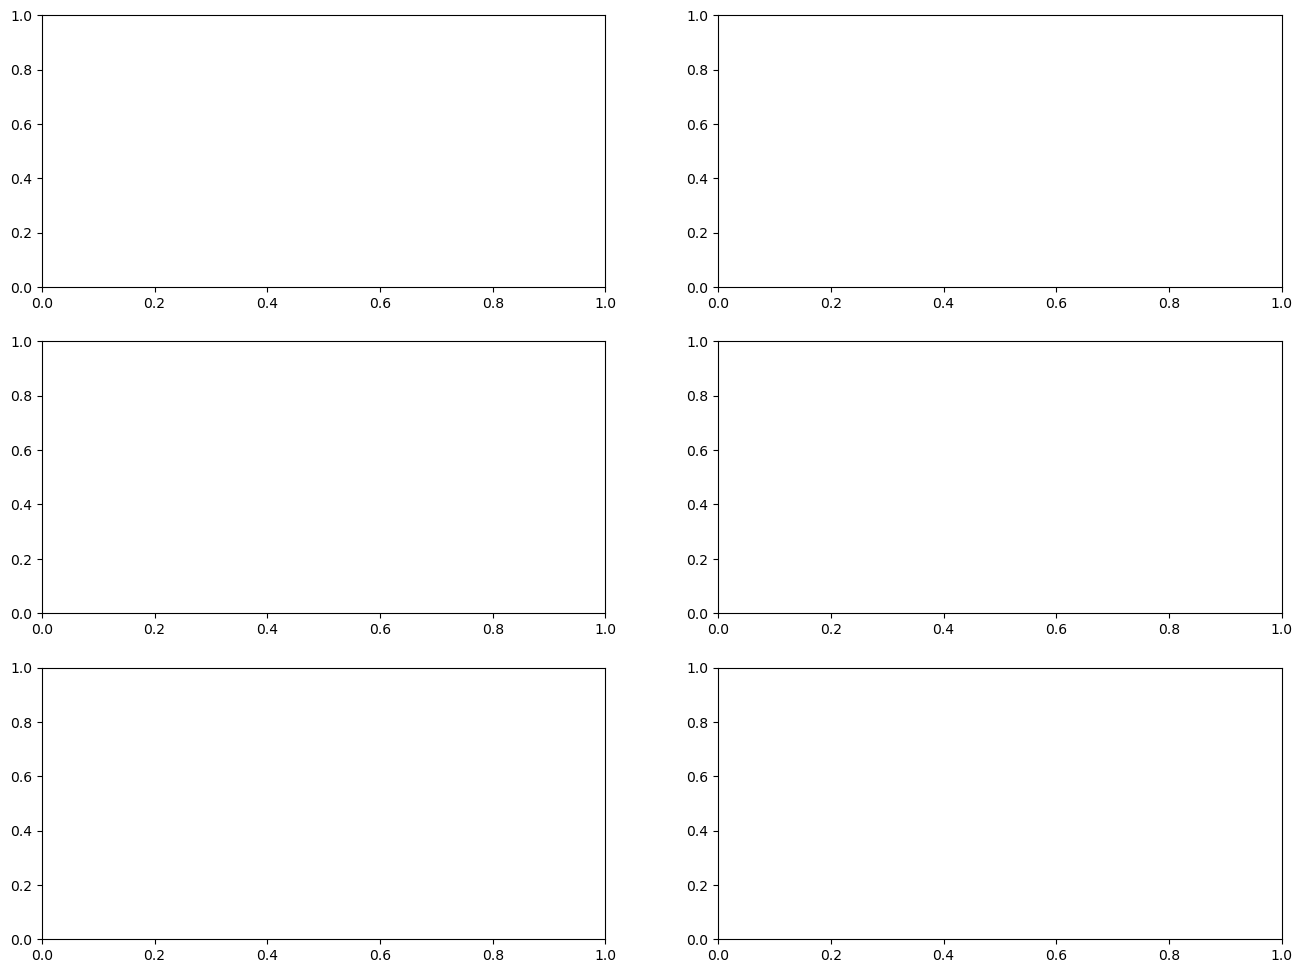

In [30]:
# Plotar Y verdadeiro vs Y previsto para cada QoI
# Configurar layout do mega plot

num_qois = len(Y.columns)
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, qoi in enumerate(Y.columns):
    ax = axes[i]
    ax.scatter(Y_val_tensor[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)], alpha=0.6, label="Previsões")
    ax.plot([Y_val_tensor[:, i].numpy().min(), Y_val_tensor[:, i].numpy().max()], [Y_val_tensor[:, i].numpy().min(), Y_val_tensor[:, i].numpy().max()], 
            color="red", linestyle="--", label="Ideal")
    r2 = r2_score(Y_val_tensor[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)])
    ax.set_title(f"{qoi}: Y Verdadeiro vs Y Previsto - R² = {round(r2,4)}")
    ax.set_xlabel("Y Verdadeiro")
    ax.set_ylabel("Y Previsto")
    ax.legend()
    ax.grid(True)

# Desativar eixos vazios, caso o número de QoIs seja menor que o total de subplots
for j in range(len(axes)):
    if j >= num_qois:
        axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f"{name}.jpg")